In [1]:
!pip install transformers

In [2]:
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

In [3]:
from IPython.display import clear_output
import os
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("display.max_colwidth", 1000)

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    StratifiedShuffleSplit,
    train_test_split,
)
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cpu":
    print("cpu")
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


## Data preparation

In our dataset we have 3218 disaster tweets and 4302 not disaster tweets.    

In [5]:
DATA_PATH = "sample_data/"
TRAIN_FEATURES = os.path.join(DATA_PATH, "train_new_features.csv")

In [6]:
train_df = pd.read_csv(
    TRAIN_FEATURES, index_col=0, encoding="utf-8"
)

In [7]:
train_df.head(2)

,text,target,text_cleaned,preprocessed_text,sentence_count,word_count,stop_word_count,stop_word_share,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,polarity_raw,subjectivity_raw,unique_word_count,unique_word_share,polarity,subjectivity,DT,NN,PRP$,NNS,VBP,IN,MD,VB,JJ,PRP,JJS,VBN,VBD,TO,VBG,CC,RB,EX,VBZ,CD,WP,RP,JJR,WRB,FW,WDT,NNP,RBR,RBS,PDT,SYM,UH,WP$
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,our deeds are the reason of this earthquake may allah forgive us all,deed reason earthquake allah forgive,1,13,6,0.461538,0,4.384615,69,1,1,0,0.0,0.0,5,1.0,0.0,0.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,1,7,0,0.000000,0,4.571429,38,1,0,0,0.1,0.4,7,1.0,0.1,0.4,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_df.shape

(7520, 53)

An input sentence for a classification task should go through the following steps before being fed into the BERT model:

- Adding the [CLS] token at the beginning of the sentence
- Adding the [SEP] token at the end of the sentence
- Tokenization: breaking down of the sentence into tokens
- Converting each token into their corresponding IDs in the model
- Padding the sentence with [PAD] tokens so that the total length equals to the maximum length

### Adding the [CLS] and [SEP] tokens

In [9]:
text = train_df["text"].values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in text]
labels = train_df["target"].values

In [10]:
assert len(sentences) == len(labels) == train_df.shape[0]

In [11]:
print(sentences[1000])

[CLS] @Drake is body bagging meek meanwhile he's on tour with Nicki all hush hush...he's put 2 diss tracks out and meek 0 but dude started it lol [SEP]


### Holdout set split

Let's split our samples to make a holdout set.

In [12]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(
    sentences, labels, test_size=0.3
)

We have 5264 samples in train set and 2256 in test set.

In [13]:
print(len(train_gt), len(test_gt))

5264 2256


### Tokenization

Let's use tokenizer for pretrained model BERT Base presents 12 layers (transformers blocks), hidden size of 768, 12 self-attention heads and a final number of parameters of 110 million.
This model is trained on lower-cased English text.

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print(tokenized_texts[0])

['[CLS]', 'spot', 'flood', 'combo', '53', '##in', '##ch', '300', '##w', 'curved', 'cree', 'led', 'work', 'light', 'bar', '4', '##x', '##4', 'off', '##ro', '##ad', 'fog', 'lamp', '-', 'full', 're', '##u', '_', 'http', ':', '/', '/', 't', '.', 'co', '/', 'xx', '##kh', '##j', '##ys', '##n', '##0', '##p', 'http', ':', '/', '/', 't', '.', 'co', '/', 'je', '##v', '##h', '##k', '##n', '##j', '##gb', '##x', '[SEP]']


### Input IDs

In [15]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

### Padding the sentence

In [17]:
input_ids = pad_sequences(
    input_ids,
    maxlen=250,
    dtype="long",
    truncating="post",
    padding="post",
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

### Train - validation set split

In [18]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1,
)

### Prepare model input

In [19]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [20]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [21]:
train_labels

tensor([1, 1, 0,  ..., 0, 0, 1])

In [22]:
train_inputs

tensor([[  101,  4040,  4053,  ...,     0,     0,     0],
        [  101,  5729,  8505,  ...,     0,     0,     0],
        [  101,  1005, 14976,  ...,     0,     0,     0],
        ...,
        [  101,  1045,  1005,  ...,     0,     0,     0],
        [  101,  1998,  2059,  ...,     0,     0,     0],
        [  101,  2149,  5620,  ...,     0,     0,     0]])

To make our data generated in parallel by the CPU, which can then be fed to the GPU for neural network computations, we will use DataLoader iterator.

In [23]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32,
)

In [24]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32,
)

## Fine-tuning a BERT model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification.

We’ll be using BertForSequenceClassification. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

In [25]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

For the purposes of fine-tuning, the it is recommended choosing from the following values (from Appendix A.3 of the BERT paper):

        Batch size: 16, 32
        Learning rate (Adam): 5e-5, 3e-5, 2e-5
        Number of epochs: 2, 3, 4

In [26]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "gamma", "beta"]
optimizer_grouped_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay_rate": 0.01,
    },
    {
        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay_rate": 0.0,
    },
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

We chose to run for 1 epoch. Below is our training loop.

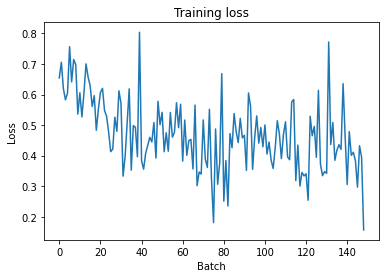

Loss on Training set: 0.46973


In [27]:
train_loss_set = []
train_loss = 0

model.train()

for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(
        b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels
    )
    train_loss_set.append(loss[0].item())

    # Backward pass
    loss[0].backward()

    optimizer.step()
    train_loss += loss[0].item()

    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("Loss on Training set: {0:.5f}".format(train_loss / len(train_dataloader)))

Put the model in evaluation mode.

In [28]:
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate([label_ids])
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

Report the final F1-score for this validation run.

In [29]:
print(
    "\nf1_score:  {:.2f}".format(
        f1_score(valid_labels, valid_preds, average="macro")
    )
)


f1_score:  0.84


## Performance on test set

**Data preparation.**

In [30]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=250,
    dtype="long",
    truncating="post",
    padding="post",
)

In [31]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels,
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32,
)

In [32]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate([label_ids])
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [33]:
def get_scores(y_test, y_pred, name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = roc_auc_score(y_test, y_pred)
    columns = ["accuracy", "precision", "recall", "F1-macro", "AUC-ROC"]
    results = pd.DataFrame(
        [accuracy, precision, recall, f1, roc_auc], index=columns, columns=[name]
    ).T
    return results

In [34]:
results_bert = get_scores(test_labels, test_preds, name="BERT")
results_bert

,accuracy,precision,recall,F1-macro,AUC-ROC
BERT,0.837766,0.824044,0.786236,0.832977,0.831052


F1-score on holdout set equal to 0.83 is not so different from the result on validation set (0.84).
Without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score.

## Mispredicted tweets

In [35]:
print(
    "Number of mispredicted tweets: {0}/{1}".format(
        sum([z[0] != z[1] for z in zip(test_labels, test_preds)]),
        len(test_labels),
    )
)

Number of mispredicted tweets: 366/2256


**Predicted Neg/Actual Pos**

In [36]:
def find_fn(ypred, ytrue):
    z = [(i == 0) & (i != j) for i, j in zip(ypred, ytrue)]
    index_list = [index for index, element in enumerate(z, start=1) if element]
    y_fn = [test_sentences[i] for i in index_list]
    return y_fn


fn = find_fn(test_preds, test_labels)

In [37]:
print(
    "Number of False Negatives (Predicted Not Disaster/Actual Disaster): ",
    len(fn),
    "\n",
)
fn

Number of False Negatives (Predicted Not Disaster/Actual Disaster):  205 



['[CLS] #what #tribal Olap #world pres: http://t.co/Jw6FNnsSxT How To Recognize A Hazardous Waste And The Multidimensi http://t.co/4zAzTB19qE [SEP]',
 '[CLS] In Lies We Trust #dvd CIA Hollywood and Bioterrorism Len Horowitz Vaccines Nwo http://t.co/6PAGJqfbzK http://t.co/qzizElxbyr [SEP]',
 '[CLS] @suelinflower there is no words to describe the physical painthey ripped you apart while you screamed for dear lifeits like been engulfed [SEP]',
 '[CLS] No #news of #hostages in #Libya\n\nhttp://t.co/k9FBtcCU58\n\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/XYj0rPsAI2 [SEP]',
 "[CLS] @susanj357 @msnbc @allinwithchris it's like watching a hostage video sometimes ... But not always ( at least not yet) [SEP]",
 "[CLS] Sadly How Windows 10 Reveals Microsoft's Ethics Armageddon http://t.co/sTfTjCrjEa [SEP]",
 '[CLS] #Glaucoma occurs when fluid builds up pressure inside #eye to a level that may damage optic nerve #eyefacts [SEP]',
 '[CLS] 70 years ago today 1945 #Hirosh

**Predicted Pos/ Actual Neg**

In [38]:
def find_fp(ypred, ytrue):
    z = [(i == 1) & (i != j) for i, j in zip(ypred, ytrue)]
    index_list = [index for index, element in enumerate(z, start=1) if element]
    y_fp = [test_sentences[i] for i in index_list]
    return y_fp


fp = find_fp(test_preds, test_labels)

In [39]:
print(
    "Number of False Negatives (Predicted Not Disaster/Actual Disaster): ",
    len(fp),
    "\n",
)
fp

Number of False Negatives (Predicted Not Disaster/Actual Disaster):  161 



['[CLS] Severe weather and a rare hailstorm pummel Boston - http://t.co/jkYM9EdOfc [SEP]',
 '[CLS] Traffic Collision - Ambulance Enroute: Elkhorn Blvd at Walerga Rd Sacramento http://t.co/5qHQo6eJtu [SEP]',
 '[CLS] @BubblyCuteOne ?????????? ok ok okayyyyyy Ima act right ....bout to get this blizzard tho [SEP]',
 '[CLS] Newlyweds feed thousands of Syrian refugees instead of hosting a banquet wedding dinner -  http://t.co/XZV0lT9ZZk via @smh [SEP]',
 '[CLS] @ChristophersZen @HunterLove1995 @tblack yeah man..... That movie BOMBED hard [SEP]',
 '[CLS] REPORTED: HIT &amp; RUN-IN ROADWAY-PROPERTY DAMAGE at 15901 STATESVILLE RD [SEP]',
 '[CLS] @Flow397 Coming atcha from Boston. Had golfball sized hail yesterday sunny amazing skies today! #ParkChat [SEP]',
 '[CLS] #stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp [SEP]',
 '[CLS] #love #food #fun Malaysian Prime Minister Najib Razak confirmed that the aircraft 

## Conclusions

We used BERT to train a text classifier. Specifically, we took the pre-trained BERT model, added an untrained layer of neurons on the end, and trained the new model for our classification task.
The result showed the superiority of BERT in comparison to traditional methods based on tf-idf and feature engineering with machine learning algoritms. 